Potential Other Questions: Can we determine position type based on weight or other statistics?

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import urllib2
import urllib
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import json
import re
import seaborn as sns
from sklearn import tree

In [3]:
#All active players don't have "years played" information -> set values to "Active"
#All retired players don't have "current team" information -> set values to "Retired"
#All retired players don't have "Position" information -> set values to "TBD"
    #These positions will have to be updated based on crossreferencing with the other .csv statistics files
Basic_Stats = pd.read_csv("./Basic_Stats.csv");
Basic_Stats = pd.DataFrame(data = Basic_Stats)

print Basic_Stats.info(), "\n\n"
Basic_Stats['Current Team'].replace(np.nan,'Retired', inplace=True);
Basic_Stats['Years Played'].replace(np.nan,'Active', inplace=True);
#Basic_Stats['Position'].replace(np.nan,0, inplace=True);

#Assign positions to numerical values
'''
Basic_Stats['Position'].replace(['QB'],1, inplace=True);
Basic_Stats['Position'].replace(['RB'],2, inplace=True);
Basic_Stats['Position'].replace(['FB'],3, inplace=True);
Basic_Stats['Position'].replace(['WR'],4, inplace=True);
Basic_Stats['Position'].replace(['TE'],5, inplace=True);
Basic_Stats['Position'].replace(['OL','OG','G','C','T','OT'],6, inplace=True);
Basic_Stats['Position'].replace(['DE','DT','NT','DL'],7, inplace=True);
Basic_Stats['Position'].replace(['OLB', 'ILB','LB','MLB'],8, inplace=True);
Basic_Stats['Position'].replace(['SS','FS','SAF','LS'],9, inplace=True);
Basic_Stats['Position'].replace(['CB','DB'],10, inplace=True);
Basic_Stats['Position'].replace(['K','P'],11, inplace=True);
'''

#Assign positions to positional groups

Basic_Stats['Position'].replace(['QB','RB','FB','WR','TE'],0, inplace=True);
Basic_Stats['Position'].replace(['OL','OG','G','C','T','OT'],1, inplace=True);
Basic_Stats['Position'].replace(['DE','DT','NT','DL'],2, inplace=True);
Basic_Stats['Position'].replace(['OLB', 'ILB','LB','MLB'],3, inplace=True);
Basic_Stats['Position'].replace(['SS','FS','SAF','LS','CB','DB'],4, inplace=True);
Basic_Stats['Position'].replace(['K','P'],5, inplace=True);


#Delete sparse data 
Basic_Stats = Basic_Stats.drop(['Number'], axis=1)
Basic_Stats = Basic_Stats.drop(['High School'], axis=1)
Basic_Stats = Basic_Stats.drop(['High School Location'], axis=1)
Basic_Stats = Basic_Stats.drop(['Age'], axis=1)
Basic_Stats = Basic_Stats.dropna(axis = 0, how="any")
Data = Basic_Stats.drop(['Position'], axis=1)
#Turn experience column into int64 data type by removing "Seasons"
Basic_Stats['Experience'] = pd.Series(Basic_Stats['Experience']).str.replace(' Seasons', '')
Basic_Stats['Experience'] = pd.to_numeric(Basic_Stats['Experience'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17172 entries, 0 to 17171
Data columns (total 16 columns):
Age                     13504 non-null float64
Birth Place             14794 non-null object
Birthday                16835 non-null object
College                 17133 non-null object
Current Status          17172 non-null object
Current Team            3096 non-null object
Experience              17133 non-null object
Height (inches)         17026 non-null float64
High School             2514 non-null object
High School Location    2510 non-null object
Name                    17172 non-null object
Number                  1708 non-null float64
Player Id               17172 non-null object
Position                3096 non-null object
Weight (lbs)            17121 non-null float64
Years Played            14076 non-null object
dtypes: float64(4), object(12)
memory usage: 2.1+ MB
None 




Correlations:
                   Experience  Height (inches)  Position  Weight (lbs)
Experience         1.000000         0.001622  0.057819      0.063097
Height (inches)    0.001622         1.000000 -0.236948      0.701241
Position           0.057819        -0.236948  1.000000     -0.219841
Weight (lbs)       0.063097         0.701241 -0.219841      1.000000 


[[ 1.          0.70124147]
 [ 0.70124147  1.        ]]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2514 entries, 4 to 17157
Data columns (total 12 columns):
Birth Place        2514 non-null object
Birthday           2514 non-null object
College            2514 non-null object
Current Status     2514 non-null object
Current Team       2514 non-null object
Experience         2514 non-null int64
Height (inches)    2514 non-null float64
Name               2514 non-null object
Player Id          2514 non-null object
Position           2514 non-null float64
Weight (lbs)       2514 non-null float64
Years Played       2514 non-nul

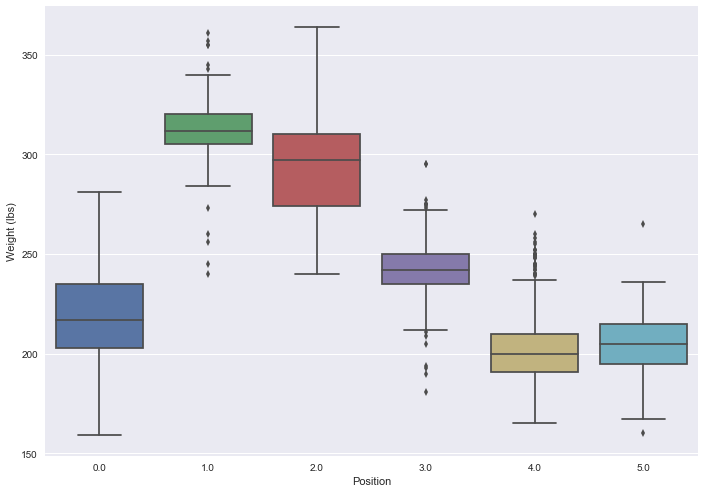

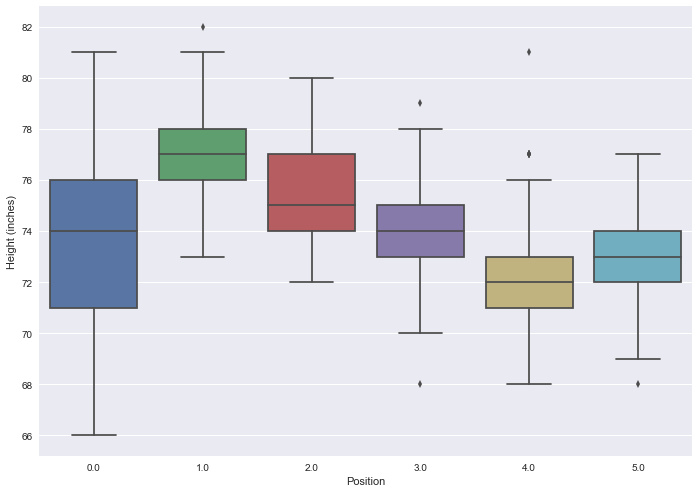

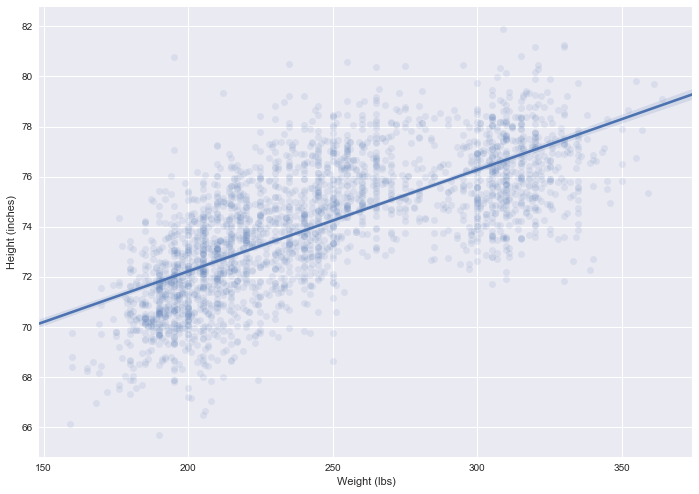

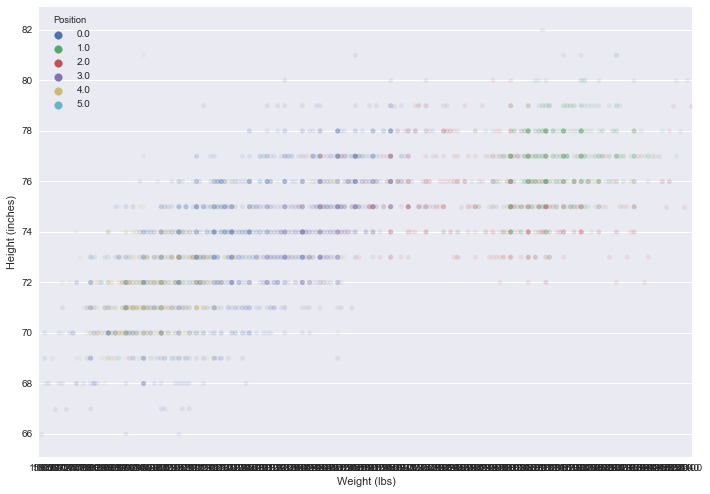

In [4]:
#################
##  TODO: Need to find way to correlate discrete data objects
#################
print "Correlations:\n ",Basic_Stats.corr(method='pearson'), "\n\n"

coef = np.corrcoef(Basic_Stats['Weight (lbs)'],Basic_Stats['Height (inches)'])
print coef;
#Box plot of Weight ranges for each position
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.figure()
sns.boxplot(x="Position", y="Weight (lbs)", data=Basic_Stats);
plt.figure()
sns.boxplot(x="Position", y="Height (inches)", data=Basic_Stats);
plt.figure()
sns.regplot(x="Weight (lbs)", y="Height (inches)", data=Basic_Stats, y_jitter=.5, scatter_kws={'alpha':0.1});
plt.figure()
sns.stripplot(x="Weight (lbs)", y="Height (inches)", data=Basic_Stats, hue = 'Position', alpha=0.1);
print Basic_Stats.info(), "\n\n"

In [27]:
"""
Standardize Defensive Career Stats and Group By Player ID
"""
Defensive_Stats = pd.read_csv("./Career_Stats_Defensive.csv");
Defensive_Stats = Defensive_Stats.drop(['Name'], axis=1)
Defensive_Stats = Defensive_Stats.drop(['Position'], axis=1)
Defensive_Stats = Defensive_Stats.drop(['Year'], axis=1)
Defensive_Stats = Defensive_Stats.drop(['Team'], axis=1)
Defensive_Stats['Total Tackles'].replace('--',0, inplace=True);
Defensive_Stats['Total Tackles'] = pd.to_numeric(Defensive_Stats['Total Tackles'])
Defensive_Stats['Solo Tackles'].replace('--',0, inplace=True);
Defensive_Stats['Solo Tackles'] = pd.to_numeric(Defensive_Stats['Solo Tackles'])
Defensive_Stats['Assisted Tackles'].replace('--',0, inplace=True);
Defensive_Stats['Assisted Tackles'] = pd.to_numeric(Defensive_Stats['Assisted Tackles'])
Defensive_Stats['Sacks'].replace('--',0, inplace=True);
Defensive_Stats['Sacks'] = pd.to_numeric(Defensive_Stats['Sacks'])
Defensive_Stats['Ints'].replace('--',0, inplace=True);
Defensive_Stats['Ints'] = pd.to_numeric(Defensive_Stats['Ints'])
Defensive_Stats = Defensive_Stats.groupby(Defensive_Stats['Player Id']).sum()

print Defensive_Stats.info()
print Defensive_Stats

<class 'pandas.core.frame.DataFrame'>
Index: 4302 entries, a'shawnrobinson/2555265 to zurlontipton/2550407
Data columns (total 7 columns):
Games Played        4302 non-null int64
Total Tackles       4302 non-null int64
Solo Tackles        4302 non-null int64
Assisted Tackles    4302 non-null int64
Sacks               4302 non-null float64
Ints                4302 non-null int64
Yards Per Int       4302 non-null float64
dtypes: float64(2), int64(5)
memory usage: 268.9+ KB
None
                         Games Played  Total Tackles  Solo Tackles  \
Player Id                                                            
a'shawnrobinson/2555265            16             30            22   
a.j.bouye/2541162                  50            140           117   
a.j.edds/496921                    17             14             4   
a.j.feeley/2504566                 28              2             2   
a.j.francis/2541707                 3              2             1   
a.j.green/2495450            